In [88]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
#https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089
import json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('words')
nltk.download('stopwords')
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
sw_nltk.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
import re
import spacy
import os

from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (RepeatedStratifiedKFold, cross_val_score, )
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tomotopy import HDPModel

#from lda_classification.model import TomotopyLDAVectorizer
#from lda_classification.preprocess.spacy_cleaner import SpacyCleaner
import gensim
import gensim.corpora as corpora
import pyLDAvis
#import pyLDAvis.gensim_models as gensim
pyLDAvis.enable_notebook()
#import pyLDAvis.gensim
import pickle 

from matplotlib import pyplot as plt
#from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
workers = 4 #Numbers of workers throughout the project
use_umap = False #make this True if you want to use UMAP for your visualizations
min_df = 5 #Minimum number for document frequency in the corpus
rm_top = 5 #Remove top n frequent words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
#lem for lemmatization, stem for stemmatizing
def preprocess(data, type="lem"):
    words = set(nltk.corpus.words.words())
    preprocessed_data = []
    for x in data:
        #Lowerize
        x = x.lower()
        #Eliminate special characters
        x = re.sub(r'\d+', '', x)
        x = re.sub(' +', ' ', x.translate ({ord(c): "" for c in "!@#$%^&*()[]{};:,./<>?\\|'`~-=_+"}).strip())
        
        #Eliminate stop words
        words = [word for word in x.split() if word not in sw_nltk] 
        x = " ".join(words)

        #Stemming / Lemmatizing
        words = word_tokenize(x)
        rootWords = []
        if type=='stem':
                ps = PorterStemmer()
                rootWords.append(ps.stem(w))
        else:
            for w in words:
                wordnet_lemmatizer = WordNetLemmatizer()
                rootWords.append(wordnet_lemmatizer.lemmatize(w))

        x = x.split(' ')
        #x = TreebankWordDetokenizer().detokenize(rootWords)

        nlp = spacy.load("en_core_web_sm")
        
        article = []
        for sent in x:
            doc = nlp(sent)
            j = [token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']]
            
            if (j != []):
                #print(j)
                #print(j[0] in words)
                #print(j[0].isalpha())
                if((j[0] in words) or (j[0].isalpha())):
                    article.append(j[0])
        
        if article != []:
            preprocessed_data.append(article)

        #print(article)
    return preprocessed_data
        
    


#preprocess(['Hsf##123 14: . ; ,  45', 'Blu34%& 22', 'as fine as good', 'found, find, go, went', 'studies studying cries cry'])

In [10]:
#Carefull!!! Takes about 90 minutes! If you already have a model saved, then use the prep_arr() class!!!!


# Opening JSON file
f_queries = open('Queries_Labeled.json',)
f_collection = open('collection.json')
 
# returns JSON object as
# a dictionary
data_queries = json.load(f_queries)
data_collection = json.load(f_collection)

# Iterating through the json
# list
#for i in data['documents']:
#    print(i)

queries = data_queries['documents']
collection = data_collection['TREC']['DOC']
#print(len(queries))
#print(len(collection))

# Closing file
f_queries.close()
f_collection.close()

prep_collection = []
for x in collection:
    prep_collection.append(x['text'])
prep_collection = preprocess(prep_collection)

prep_queries = []
for x in queries:
    prep_queries.append(x['text'])
prep_queries = preprocess(prep_queries)

#print(prep_queries)
#print(prep_collection)

In [90]:
#Savable data array class
class prep_arr(object):
    def __init__(self, data_arr=[]):
        self.data_arr = data_arr

    def save(self, path):
        with open(path, 'wb') as outp:
            pickle.dump(self, outp, pickle.HIGHEST_PROTOCOL)

    def load(self, path):
        with open(path, 'rb') as inp:
            prep_arr_load = pickle.load(inp)
        self.data_arr = prep_arr_load.data_arr
    

In [12]:
#Save cleaned arrays
arr_q = prep_arr(prep_queries)
arr_q.save("./cleaned_data/prep_queries.txt")
arr_c = prep_arr(prep_collection)
arr_c.save("./cleaned_data/prep_collection.txt")

In [91]:
#Load the saved arrays
load_q = prep_arr()
load_q.load("./cleaned_data/prep_queries.txt")
prep_queries = load_q.data_arr

load_c = prep_arr()
load_c.load("./cleaned_data/prep_collection.txt")
prep_collection = load_c.data_arr


In [92]:
print(len(prep_collection))
print(len(prep_queries))

7849
50


In [93]:
# Create Dictionary
id2word = corpora.Dictionary(prep_collection)
# Create Corpus
texts = prep_collection
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [94]:
from pprint import pprint
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.012*"information" + 0.009*"system" + 0.006*"describe" + 0.006*"problem" + '
  '0.006*"use" + 0.005*"frequency" + 0.005*"pm" + 0.005*"present" + '
  '0.004*"function" + 0.004*"library"'),
 (1,
  '0.012*"system" + 0.007*"library" + 0.007*"datum" + 0.006*"frequency" + '
  '0.006*"use" + 0.005*"information" + 0.005*"circuit" + 0.005*"field" + '
  '0.005*"give" + 0.005*"analysis"'),
 (2,
  '0.010*"information" + 0.007*"use" + 0.007*"system" + 0.006*"describe" + '
  '0.006*"service" + 0.006*"library" + 0.005*"method" + 0.004*"electron" + '
  '0.004*"datum" + 0.004*"pm"'),
 (3,
  '0.009*"system" + 0.009*"method" + 0.008*"information" + 0.007*"library" + '
  '0.007*"give" + 0.007*"use" + 0.006*"describe" + 0.006*"result" + '
  '0.005*"work" + 0.005*"electron"')]


In [96]:
#import pyLDAvis.gensim
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    #LDAvis_prepared = gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

C:\Python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.002166  0.019156       1        1  30.752533
3     -0.015588  0.008331       2        1  28.199432
2     -0.012276 -0.020927       3        1  21.021198
0      0.025698 -0.006559       4        1  20.026837, topic_info=            Term         Freq        Total Category  logprob  loglift
200  information  2080.000000  2080.000000  Default  30.0000  30.0000
254       method  1203.000000  1203.000000  Default  29.0000  29.0000
335      problem   858.000000   858.000000  Default  28.0000  28.0000
2             pm   831.000000   831.000000  Default  27.0000  27.0000
392     electron   743.000000   743.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
360       result   165.839220   969.958294   Topic4  -5.6949  -0.1581
163        field   165.948017  1044.886966   Topic4  -5.6942  -0.2319
664         base   145.250283   672.252172   Topic4  -5.8275   0.0759
254       method   151.042504  1203.783359   Topic4  -5.7884  -0.4676
149      service   141.930968  1069.444892   Topic4  -5.8506  -0.4115

[398 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
3922       1  0.832971         abn
273        1  0.269417  absorption
273        2  0.501116  absorption
273        3  0.134709  absorption
273        4  0.096990  absorption
...      ...       ...         ...
11294      1  0.833844    yugoslav
7007       2  0.215923         zag
7007       3  0.647768         zag
7008       2  0.215950         zig
7008       3  0.647849         zig

[815 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

In [97]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=collection):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=prep_collection)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(100)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.8859,"information, use, system, describe, service, library, method, electron, datum, pm","[computer, university, part, reeve, r, pm]"
1,1,0.0,0.4985,"information, system, describe, problem, use, frequency, pm, present, function, library","[use, synthetic, image, register, real, image, surface, model, number, image, analysis, task, be..."
2,2,3.0,0.6400,"system, method, information, library, give, use, describe, result, work, electron","[training, assistant, mauritius, university, mauritius, financial, help, international, developm..."
3,3,1.0,0.7884,"system, library, datum, frequency, use, information, circuit, field, give, analysis","[electrostatic, centre, conductor]"
4,4,2.0,0.5663,"information, use, system, describe, service, library, method, electron, datum, pm","[note, interpretation, transient, echo, ionosphere, comment, note, recent, radio, work, meteor, ..."
...,...,...,...,...,...
95,95,2.0,0.9887,"information, use, system, describe, service, library, method, electron, datum, pm","[midf, form, malaysian, industrial, development, finance, berhad, midf, become, country, lead, d..."
96,96,0.0,0.5423,"information, system, describe, problem, use, frequency, pm, present, function, library","[network, revise, version, paper, present, meeting, regional, cooperation, deventer, netherland,..."
97,97,1.0,0.5657,"system, library, datum, frequency, use, information, circuit, field, give, analysis","[public, public, library, represent, ideal, goal, always, pursue, real, practice, follow, nihili..."
98,98,0.0,0.9499,"information, system, describe, problem, use, frequency, pm, present, function, library","[stabilization, direct, voltage, supply, functional, diagram, propose, study, control, stabiliza..."


In [99]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9943,"information, system, describe, problem, use, frequency, pm, present, function, library","[structure, programming, language, follow, identify, major, component, programming, language, el..."
1,1.0,0.9930,"system, library, datum, frequency, use, information, circuit, field, give, analysis","[external, storage, fragmentation, produce, firstfit, allocation, strategy, publish, comparison,..."
2,2.0,0.9938,"information, use, system, describe, service, library, method, electron, datum, pm","[list, processing, real, time, serial, computer, realtime, list, processing, system, time, requi..."
3,3.0,0.9942,"system, method, information, library, give, use, describe, result, work, electron","[variable, length, tree, structure, minimum, average, search, time, sussenguth, suggest, paper, ..."


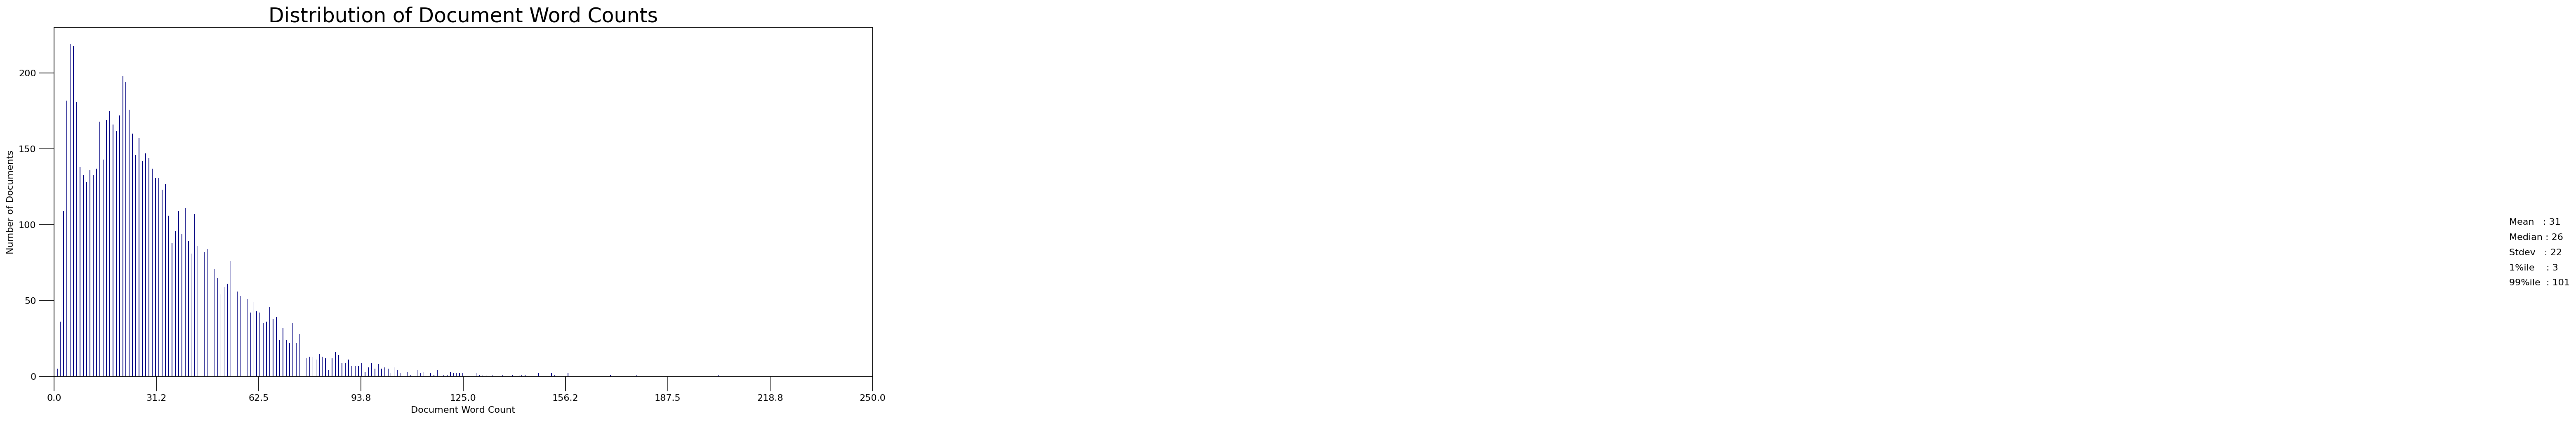

In [100]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 250), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,250,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

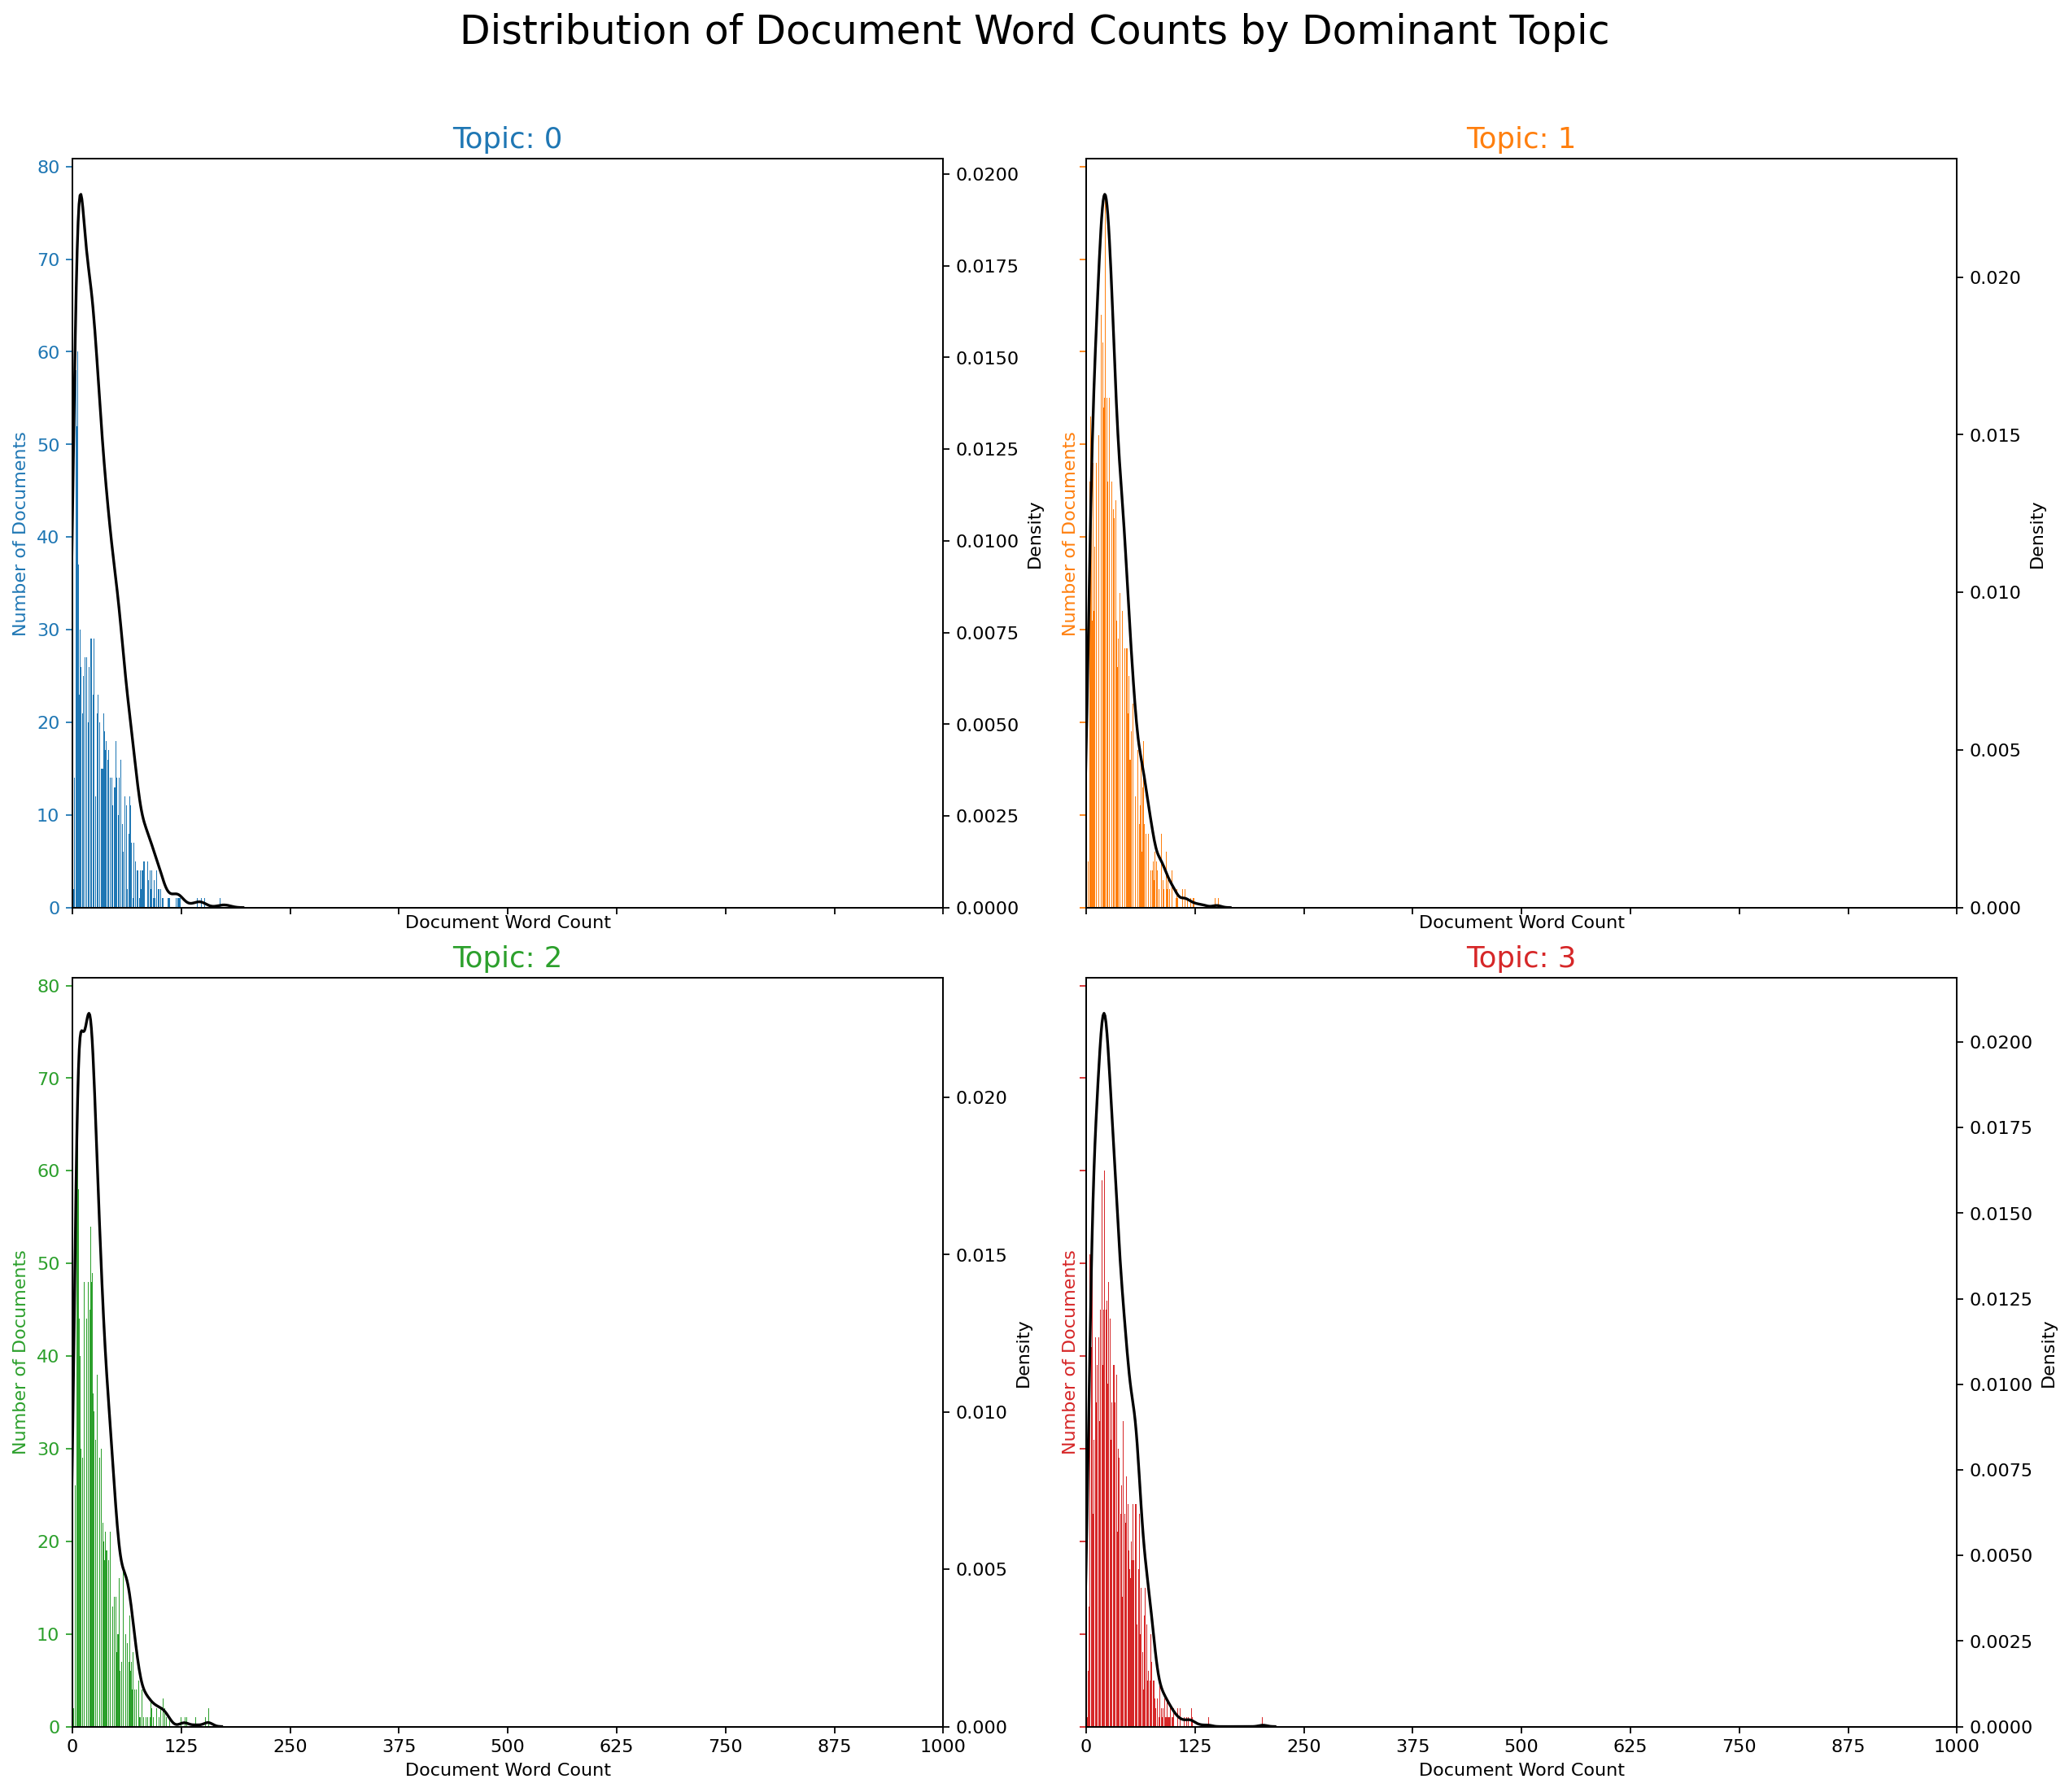

In [101]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 250, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [102]:
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    #print(row_list[0])
    topic_weights.append([i for i, w in row_list[0]])
    #print([w[0][1] for w in row_list[0]])
    #print(type(row_list[0]))
topic_weights = np.array(topic_weights)
print(topic_weights[:,1])


TypeError: cannot unpack non-iterable int object

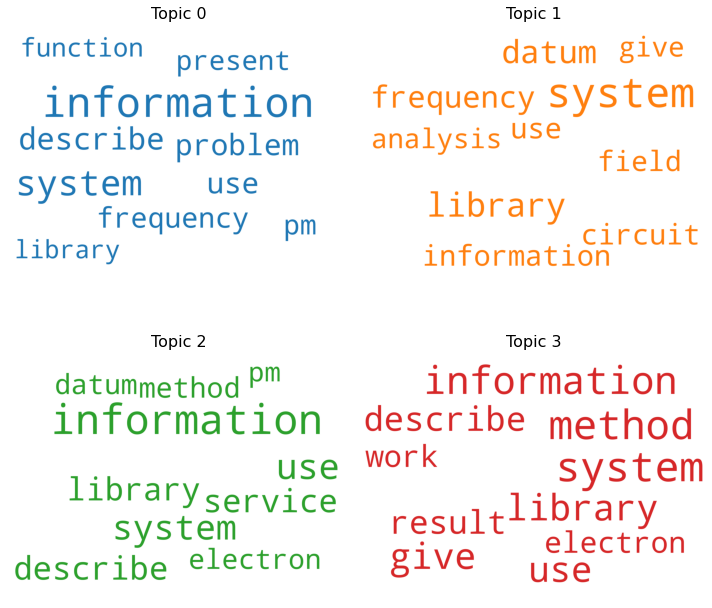

In [105]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

C:\TEMP/ipykernel_20592/4125043360.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\TEMP/ipykernel_20592/4125043360.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\TEMP/ipykernel_20592/4125043360.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\TEMP/ipykernel_20592/4125043360.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


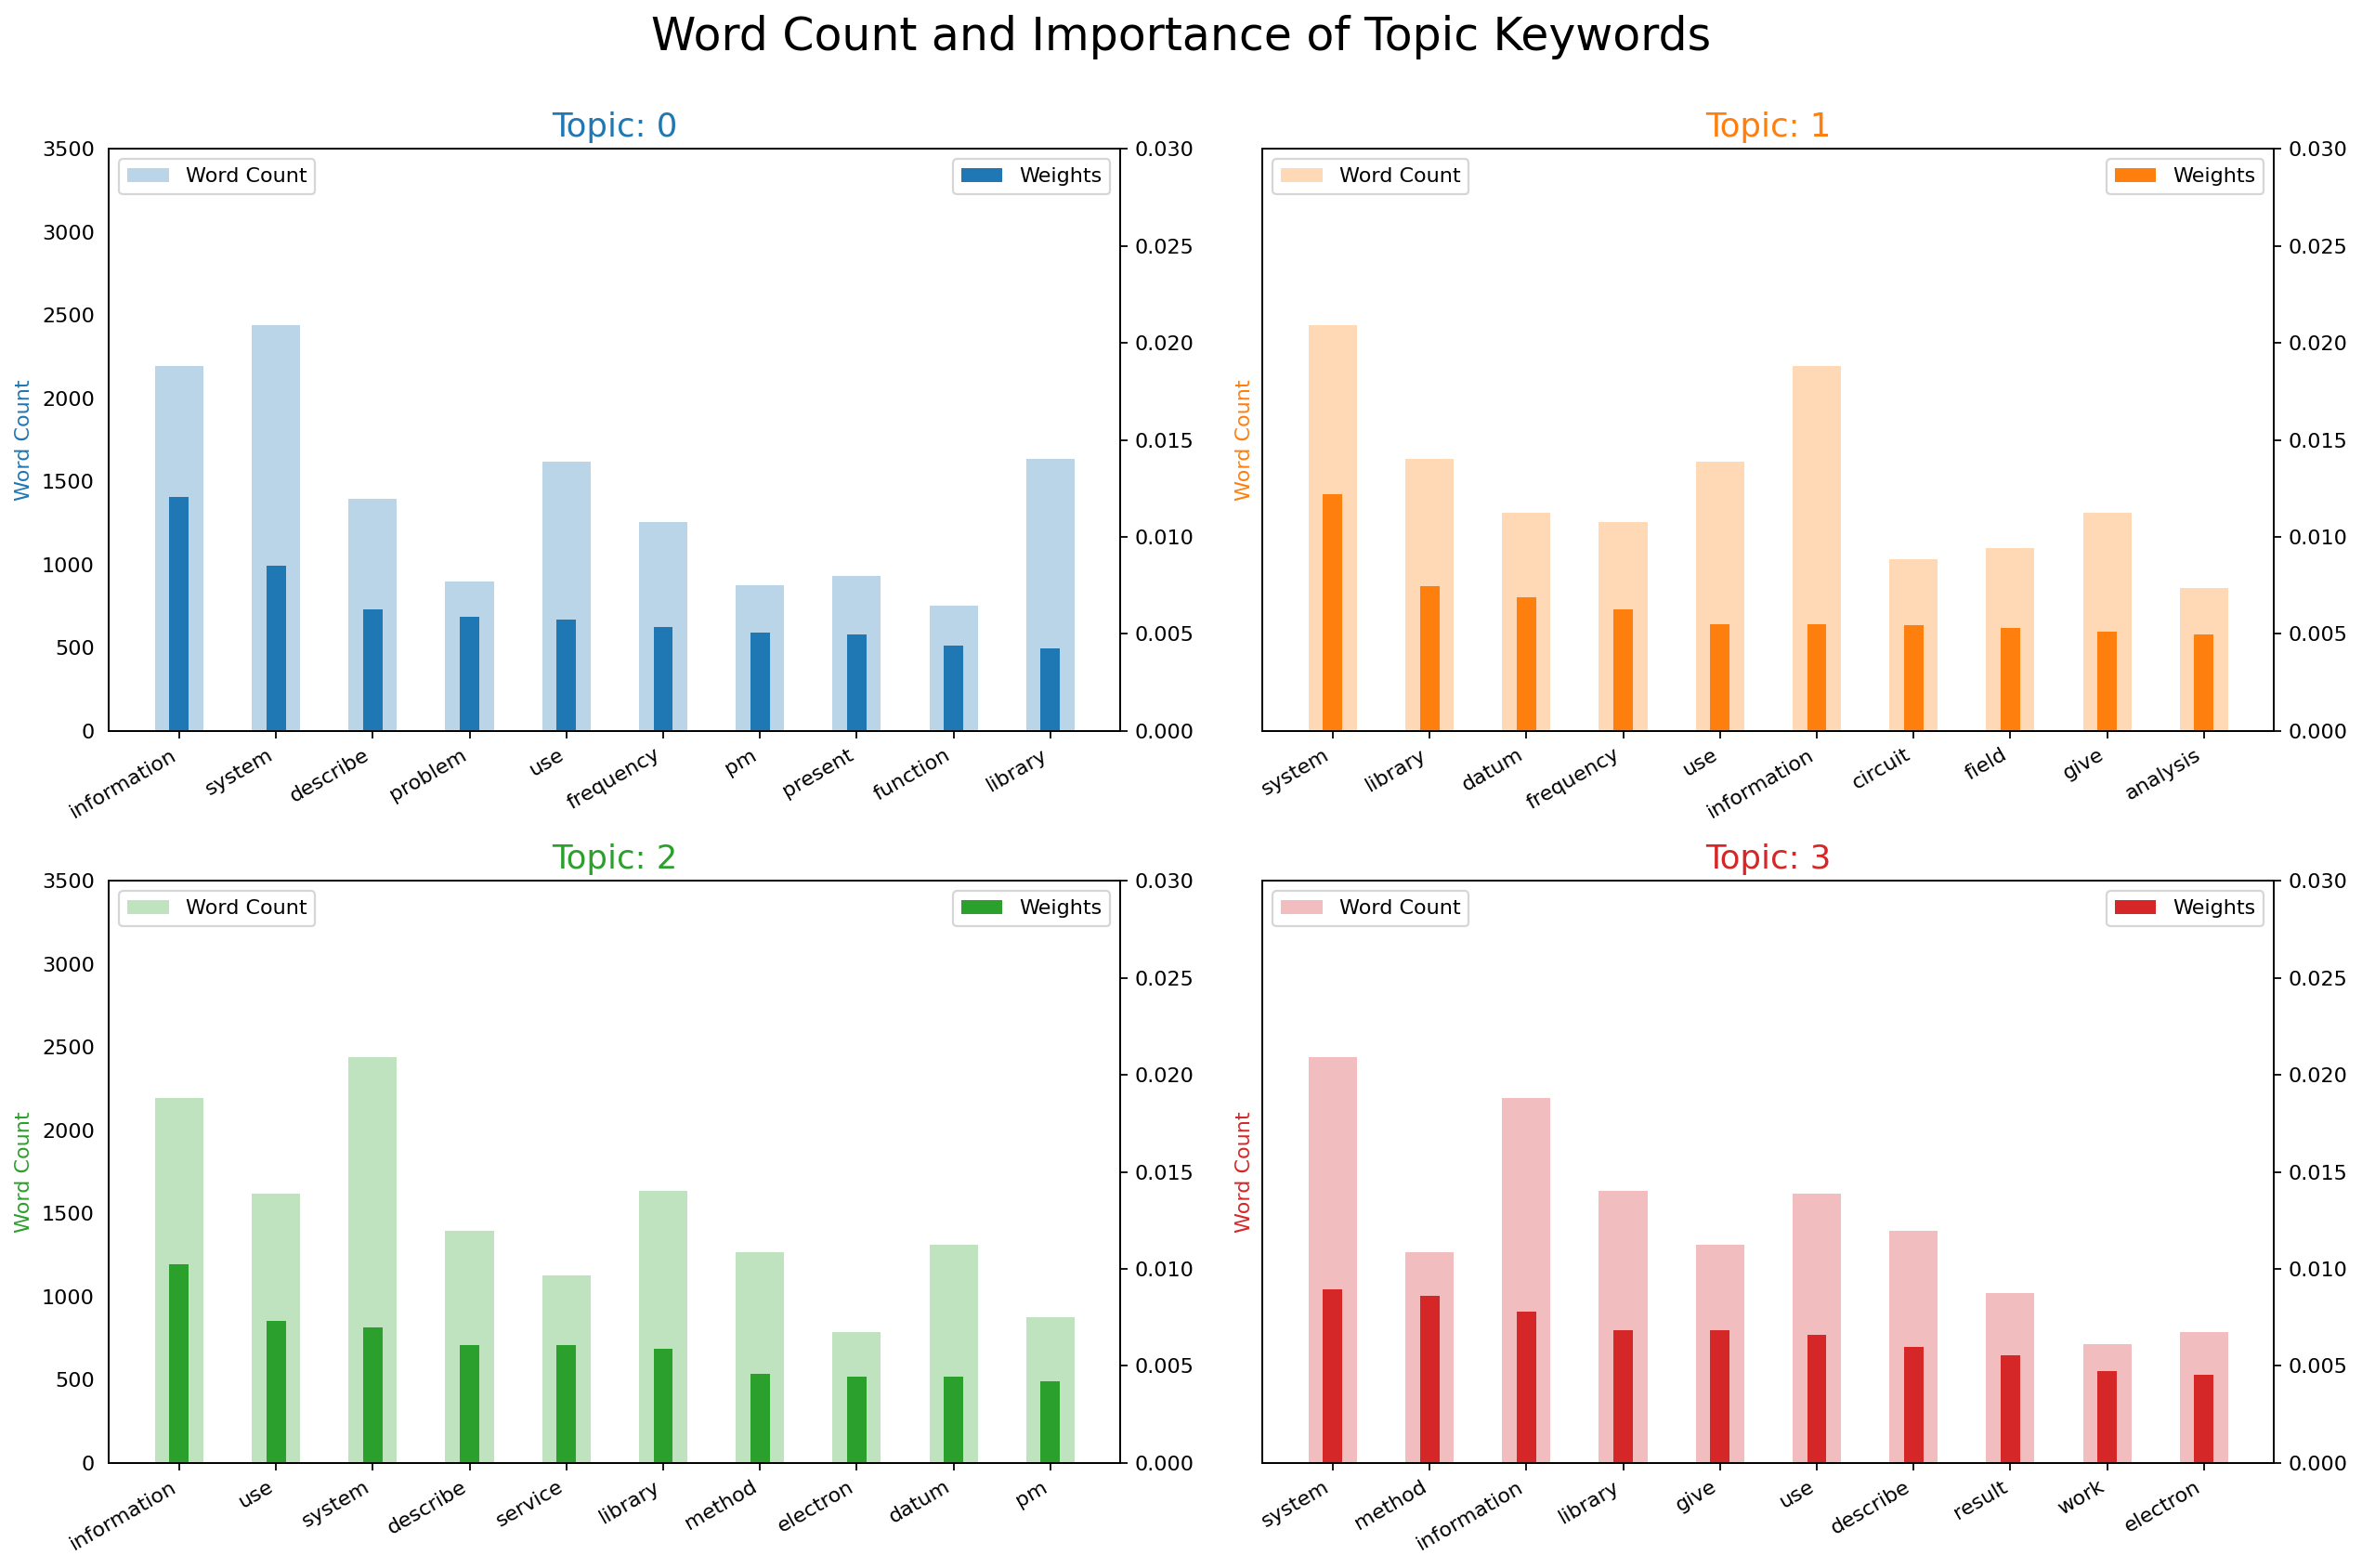

In [106]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in prep_collection for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [84]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for w in row_list[0]])
#topic_weights = np.array(topic_weights)

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

C:\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5389 samples in 0.002s...
[t-SNE] Computed neighbors for 5389 samples in 0.079s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5389
[t-SNE] Computed conditional probabilities for sample 2000 / 5389
[t-SNE] Computed conditional probabilities for sample 3000 / 5389
[t-SNE] Computed conditional probabilities for sample 4000 / 5389
[t-SNE] Computed conditional probabilities for sample 5000 / 5389
[t-SNE] Computed conditional probabilities for sample 5389 / 5389
[t-SNE] Mean sigma: 0.000374


C:\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.112331
[t-SNE] KL divergence after 1000 iterations: 0.309401


Loading BokehJS ...

In [12]:

# Parameters tuning using Grid Search
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tokens_collection = []
#tokens_collection.append(prep_collection)
#for x in prep_collection:
#    tokens_collection.append(np.array(word_tokenize(x)))

vectorizer = CountVectorizer(analyzer='word', min_df=10, stop_words='english', lowercase=True, token_pattern='[a-zA-Z0-9]{3,}', max_features=50000)
data_vectorized = vectorizer.fit_transform(prep_collection)

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
grid_params = {'n_components' : list(range(5,10))}
# LDA model
lda = LatentDirichletAllocation()
lda_model = GridSearchCV(lda,param_grid=grid_params)
lda_model.fit(tokens_collection)
# Estimators for LDA model
lda_model1 = lda_model.best_estimator_
print("Best LDA model's params" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on train data", lda_model1.perplexity(tokens_collection))

AttributeError: 'list' object has no attribute 'lower'